In [2]:
import sys
print(sys.executable) 

/opt/homebrew/Cellar/jupyterlab/3.4.3/libexec/bin/python3.10


In [3]:
import pandas as pd

In [4]:
df = pd.read_csv ('201809-citibike-tripdata.csv')
df.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,1635,2018-09-01 00:00:05.2690,2018-09-01 00:27:20.6340,252.0,MacDougal St & Washington Sq,40.732264,-73.998522,366.0,Clinton Ave & Myrtle Ave,40.693261,-73.968896,25577,Subscriber,1980,1
1,132,2018-09-01 00:00:11.2810,2018-09-01 00:02:23.4810,314.0,Cadman Plaza West & Montague St,40.693830,-73.990539,3242.0,Schermerhorn St & Court St,40.691029,-73.991834,34377,Subscriber,1969,0
2,3337,2018-09-01 00:00:20.6490,2018-09-01 00:55:58.5470,3142.0,1 Ave & E 62 St,40.761227,-73.960940,3384.0,Smith St & 3 St,40.678724,-73.995991,30496,Subscriber,1975,1
3,436,2018-09-01 00:00:21.7460,2018-09-01 00:07:38.5830,308.0,St James Pl & Oliver St,40.713079,-73.998512,3690.0,Park Pl & Church St,40.713342,-74.009355,28866,Subscriber,1984,2
4,8457,2018-09-01 00:00:27.3150,2018-09-01 02:21:25.3080,345.0,W 13 St & 6 Ave,40.736494,-73.997044,380.0,W 4 St & 7 Ave S,40.734011,-74.002939,20943,Customer,1994,1


In [5]:
x = df[['tripduration']].values.reshape(-1,1)
y = 2022 - df[['birth year']].values.reshape(-1,1)
print(x)

[[1635]
 [ 132]
 [3337]
 ...
 [1442]
 [ 453]
 [1354]]


In [6]:
# Calculate the distance between start and end stations. Expensive operation and needs to run for couple minutes.
import geopy.distance

coords_1 = df[['start station latitude','start station longitude']].values
coords_2 = df[['end station latitude','end station longitude']].values

distances = []
for i in range(len(coords_1)):
    distances.append(geopy.distance.geodesic(coords_1[i], coords_2[i]).km)

In [7]:
import numpy as np

distances = np.array(distances).reshape(-1,1)
x = np.append(x, distances, axis=1)
print(x)

[[1.63500000e+03 5.00263577e+00]
 [1.32000000e+02 3.29706028e-01]
 [3.33700000e+03 9.62859219e+00]
 ...
 [1.44200000e+03 5.57044674e+00]
 [4.53000000e+02 8.98595252e-01]
 [1.35400000e+03 4.13758643e+00]]


[ True  True  True ...  True  True  True]
[0. 0.]
[1. 1.]
[0.00037281 0.10683202]
(1877884, 2)
(1877884, 1)
(1877884, 2)


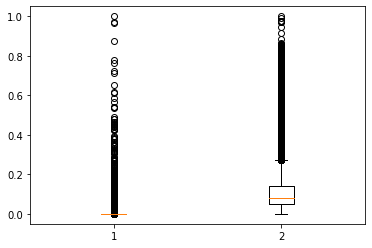

In [19]:
index = x[:,0]<1e6
print(index)
new_x = x
new_y = y

#x1 = (new_x - new_x.mean(axis=0))/ new_x.std(axis=0)
x1 = (new_x - new_x.min(axis=0))/ (new_x.max(axis=0) - new_x.min(axis=0))

import matplotlib.pyplot as plt
plt.boxplot(x1)

print(x1.min(axis=0))
print(x1.max(axis=0))
print(x1.mean(axis=0))

print(new_x.shape)
print(new_y.shape)
print(x1.shape)



In [227]:
# Use linear regression.
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state = 10)

from sklearn.linear_model import LinearRegression
regressor = LinearRegression()

regressor.fit(x_train,y_train)

print(regressor.intercept_)
print(regressor.coef_)

y_pred = regressor.predict(x_test)

df_preds = pd.DataFrame({'Actual': y_test.squeeze(), 'Predicted': y_pred.squeeze()})
print(df_preds)

[42.55121853]
[[ 1.20029861e-05 -1.66834520e-01]]
        Actual  Predicted
0           29  42.391201
1           35  42.202038
2           53  42.589472
3           31  42.257461
4           36  42.384858
...        ...        ...
187784      55  42.234092
187785      40  42.096383
187786      40  42.309674
187787      33  42.408311
187788      44  41.973019

[187789 rows x 2 columns]


(1877884, 2)
(1877884, 1)
        Actual  Predicted
0            0          0
1            0          0
2            0          0
3            0          0
4            0          0
...        ...        ...
187784       0          0
187785       0          0
187786       0          0
187787       0          0
187788       0          0

[187789 rows x 2 columns]


0.53879401995359

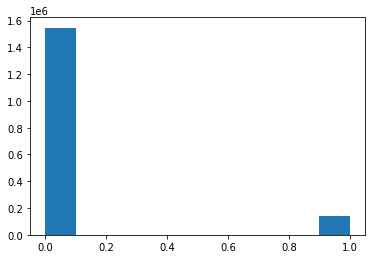

In [21]:
# Use logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

print(x1.shape)
print(new_y.shape)
x_train, x_test, y_train, y_test = train_test_split(x1, new_y, test_size = 0.1, random_state = 10)

def classify(x):
    x = np.where(x<60,0,1)
    return x
y_train = classify(y_train)
y_test = classify(y_test)

plt.hist(y_train)

regressor = LogisticRegression()
regressor.fit(x_train,y_train.squeeze())

y_pred = regressor.predict(x_test)
df_preds = pd.DataFrame({'Actual': y_test.squeeze(), 'Predicted': y_pred.squeeze()})
print(df_preds)

from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, regressor.decision_function(x_test))


In [18]:
regressor.score(x_test,y_test)

0.8720458394129488

In [254]:
print(y_pred)
type(y_pred)
count = np.count_nonzero(y_test)
print(count)
count = np.count_nonzero(y_train.squeeze())
print(count)
count = np.count_nonzero(y_pred)
print(count)



[0 0 0 ... 0 0 0]
7703
67979
0


In [260]:
print(x.min(axis=0))
print(x.max(axis=0))
print(x.mean(axis=0))

[61.  0.]
[2.43165100e+06 1.69316776e+01]
[967.51491892   1.8088454 ]
